<img style="border:2px solid black;" src="accueil.png" width=100% border="5"> </center> 
# <span style="color:blue">Porous Media - Flow modelling tools using Jupyter </span>
## <span style="color:red"> PYGRDECL based Upscaling notebook </span>

## <span style="color:blue"> 1. Create initial GRDECL ECLIPSE/PETREL Pillar Grid </span>

In [1]:
from GRDECL2VTK import *

# 1.1 Set physical dimensions in physDims (m)
physDims=[2000.0,1000,500]

# 1.2 Set model grid dimensions in gridDims
Nx=20;  Ny=Nx;  Nz=Nx
gridDims=[Nx,Ny,Nz]

# 1.3 Set corner point grid options
opt=buildCPGGrid_opt(disturbed=False,     flat=True,\
                     fault_drop=350 , fault_nx=Nx//2)

# 1.4 Create empty GeologyModel - Build CPG
Model=GeologyModel()
Model.buildCPGGrid(physDims,gridDims,opt)

# # 1.5 Compute First TPFA (block centered) Pressure values
# import time
# t0=time.time()
Model.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt)
# print("Elapsed time for TPFA: ",time.time()-t0)
# Model.plot_scalar("Pressure").show()

Model.plot_streamlines(notebook=False).show()

     Creating Grid:
       Type: CornerPoint Grid
       Grid Dimensions (NX,NY,NZ): (20 x 20 x 20)
       Number Of Grid Cells: 8000
       Created: Fields: ***PERMX***PERMY***PERMZ***PORO***
[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 64000
     NumOfCells 8000
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


[(3668.1242316349585, 3168.1242316349585, 3093.1242316349585),
 (1000.0, 500.0, 425.0),
 (0.0, 0.0, 1.0)]

## <span style="color:blue"> 2. Generate  synthetic Porosity/Permeability(mD) values </span>

[logNormLayers] Filling K and Phi Z layers with log normal distributions
[logNormLayers] Done
[UpdateListCellData] varname:PORO
[UpdateListCellData] varname:PERMX
[UpdateListCellData] varname:PERMY
[UpdateListCellData] varname:PERMZ


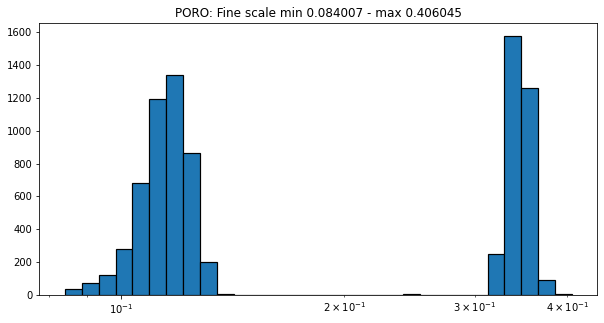

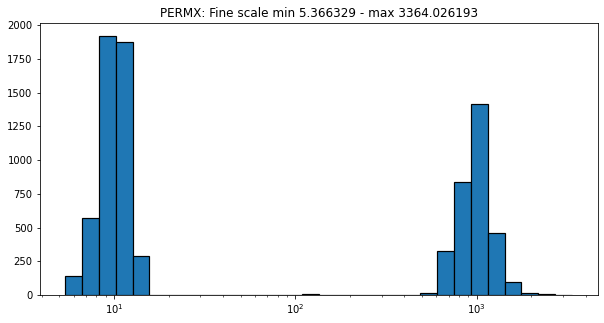

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 64000
     NumOfCells 8000
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


[(3128.882071648457, 4225.331164341864, 2141.516701727618),
 (1000.0, 500.0, 425.0),
 (-0.30307484728188816, -0.2504646618655054, 0.9194634794822787)]

In [2]:
from utils import *

# 2.1 Create random perm field with normal distribution for each layer
K_LayerPerm=[1000,10,1000,10]
# K,phi=logNormLayers(gridDims,K_LayerPerm,poro_const=0.05)
K,phi=logNormLayers_basc(gridDims,K_LayerPerm,poro_const=0.05)

# 2.2 Update porosity/permeability fields
Update_fields=["PORO","PERMX","PERMY","PERMZ"]
Update_values=[ phi  , K     , K     , 0.1*K ]
Model.UpdateListCellData(var_list=Update_fields,array_list=Update_values)

# 2.3 Visualize Fine scale histogram
for scalar in ["PORO","PERMX"]:
    Model.GRDECL_Data.Plot_hist(scalar,text="Fine scale")

# 2.3 Compute TPFA (block centered) Pressure values
Model.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt)
# Model.plot_scalar("Pressure",ITK=True).show()
Model.plot_streamlines(notebook=False).show()

## <span style="color:blue"> 3. Create coarse grid by partitoning fine gride</span>

[Partioning] Partitoning from Fine grid of size: [20,20,20] to Coarse grid of size: [4,4,4]


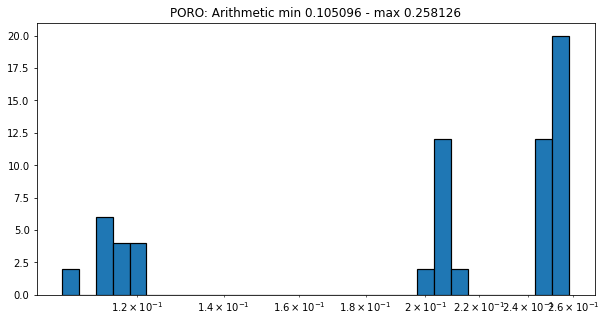

['Arithmetic_mean', 'Geometric_mean', 'Harmonic_mean', 'Harmx_mean', 'Harmy_mean', 'Harmz_mean', 'TPFA_loc', 'TPFA_glob', 'TPFA_loc_vol_average']


In [3]:
# 3.1 Set coarsening factor (grid dimensions of coarse cells)
Model.GRDECL_Data.coarse2fine_ratio=[5]*3

# 3.2 Create coarse grid and upscale porosity
Model2=Model.create_coarse_model()

# List of implemented upscaling methods
methods=Model.Upscaler.list_upscaling_methods()
print(methods)

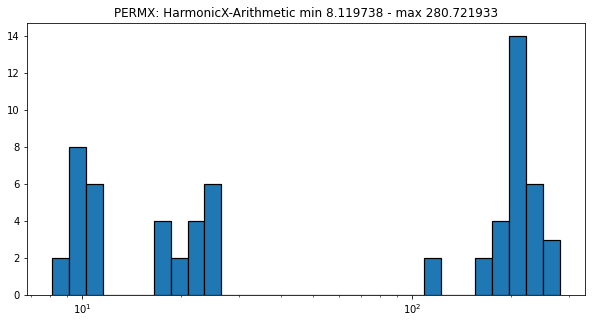

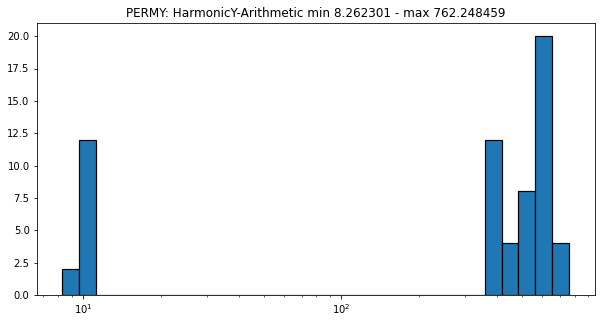

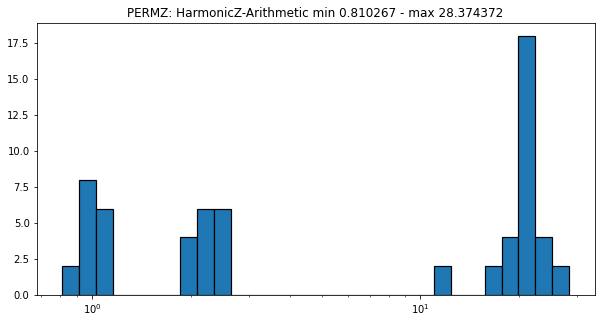

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 64000
     NumOfCells 8000
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


[(3668.1242316349585, 3168.1242316349585, 3093.1242316349585),
 (1000.0, 500.0, 425.0),
 (0.0, 0.0, 1.0)]

In [4]:
# 3.3 Upscaling
Model.Upscale_Perm(['Harmx_mean','Harmy_mean','Harmz_mean'])

# 3.3 Compute Pressure for coarse model
Model2.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt)
# # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()

Model.plot_streamlines(notebook=False).show()

In [14]:
# # 3.3 Upscaling
# Model.Upscale_Perm('Harmz_mean')

# # 3.3 Compute Pressure for coarse model
# Model2.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
# # # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()



In [15]:
# # 3.3 Upscaling
# Model.Upscaler.nlayer=0
# Model.Upscaler.Lin_BC=False
# Model.Upscale_Perm('TPFA_loc')

# # 3.3 Compute Pressure for coarse model
# Model2.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
# # # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()


In [16]:
# # 3.3 Upscaling
# Model.Upscaler.nlayer=0
# Model.Upscaler.Lin_BC=True
# Model.Upscale_Perm('TPFA_loc')

# # 3.3 Compute Pressure for coarse model
# Model2.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
# # # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()


[UPSCALING TPFA loc], nlayer: 0


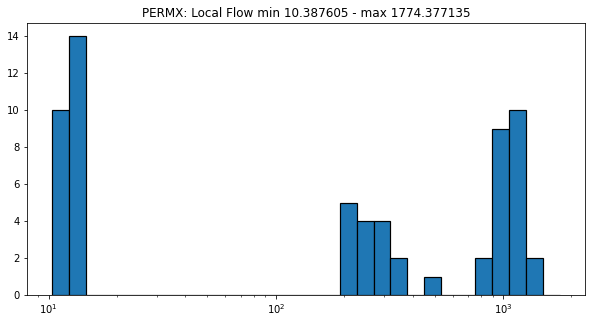

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 64000
     NumOfCells 8000
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


[(5047.01403911573, 1054.990387760985, 2586.093191652323),
 (1000.0, 500.0, 425.0),
 (-0.4342565274867892, -0.22739234673338476, 0.8716157347032001)]

In [5]:
# 3.3 Upscaling
Model.Upscaler.nlayer=0
Model.Upscaler.Lin_BC=True
Model.Upscale_Perm('TPFA_loc')

# 3.3 Compute Pressure for coarse model
Model2.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt )
# # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()
Model.plot_streamlines(notebook=False).show()

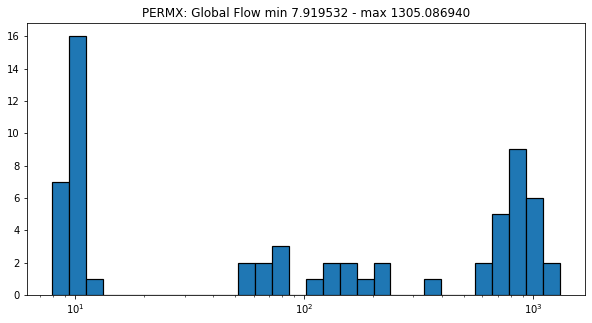

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 64000
     NumOfCells 8000
     .....Done!
[Output] Writing "Results/PILLAR_Grid.vtu" Paraview file....Done!


In [ ]:
# 3.3 Upscaling
Model.Upscaler.nlayer=0
Model.Upscaler.Lin_BC=False
Model.Upscale_Perm('TPFA_glob')

# 3.3 Compute Pressure for coarse model
Model2.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt )
# # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()
Model.plot_streamlines(notebook=False).show()